In [11]:
import numpy as np
import torch

ModuleNotFoundError: No module named 'numpy'

# Automatic Differentiation

Let $x \in \mathbb{R}$ and $f(x) = \exp(x^3) + x$.
Let's compute $$\left. \frac{df}{dx} \right \vert_{x=1.5}$$

In [ ]:
def f(x: torch.Tensor) -> torch.Tensor:
    a = x**3
    b = torch.exp(a)
    c = b + x

    return c

In [ ]:
x = torch.tensor(1.5, requires_grad=True)

y = f(x) # Forward Pass
y.backward() # Backward Pass
df_dx = x.grad
print(x)
print(y)
print(df_dx.item())

tensor(1.5000, requires_grad=True)
tensor(30.7243, grad_fn=<AddBackward0>)
198.263916015625


### What happens under the hood?
PyTorch builds a *computational graph* (DAG) of the operations that are performed on the input tensor. This graph is then used to compute the gradients using the chain rule.

By the chain rule, we can write

\begin{align*}
\frac{df}{dx} &= \underbrace{\frac{df}{dc}}_{1} \cdot \frac{dc}{dx}
\end{align*}

since $c$ is really just $f(x)$.

### Step 1: Compute $\frac{dc}{dx}$

```{python}
c = b + x
```

\begin{align*}
\frac{dc}{dx} = \frac{db}{dx} + \underbrace{\frac{dx}{dx}}_{1}
\end{align*}

### Step 2: Compute $\frac{db}{dx}$

```{python}
b = torch.exp(a)
```

\begin{align*}
\frac{db}{dx} &= \exp(a) \cdot \frac{da}{dx}
\end{align*}

### Step 3: Compute $\frac{da}{dx}$

```{python}
a = x**3
```

\begin{align*}
\frac{da}{dx} &= 3x^2 \cdot \underbrace{\frac{dx}{dx}}_{1}
\end{align*}

### Putting things together

\begin{align*}
\frac{df}{dx} &= \exp(a) \cdot 3x^2 + 1
\end{align*}

Let's check if our calculation matches the derivative that tensorflow computed:

In [ ]:
# Let's simulate the forward pass
a = x**3
b = torch.exp(a)
c = b + x

manual_derivative = b * 3*x**2 + 1

print(manual_derivative.item())

198.263916015625


Note how we need the results from the forward pass (`b`) to compute the gradients. This is why we need to keep track of the intermediate results.

## How does PyTorch know how to derive primitive functions?
e.g., `torch.exp`, `torch.sum`, `x**3` etc.

Answer: They are hardcoded in the framework, see [https://github.com/pytorch/pytorch/blob/main/tools/autograd/derivatives.yaml](https://github.com/pytorch/pytorch/blob/main/tools/autograd/derivatives.yaml).

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

Let $\mathbf{y} = (y_1, \dots, y_n)^T$ and $\hat{\mathbf{y}} = (\hat{y}_1, \dots, \hat{y}_n)^T$.
The *mean squared error function* is given by
$$\mathcal{L}(\hat{\mathbf{y}}, \mathbf{y}) = \frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2 $$

In [ ]:
def loss_fn(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

For performance reasons, *avoid loops at all costs*. Instead, use the built-in functions that operate on the entire tensor at once.

In [ ]:
# Do *not* do this:
def loss_fn_slow_please_dont_do_this(y_pred, y_true):
    loss = 0
    for y_hat, y in zip(y_pred, y_true):
        loss += (y_hat - y) ** 2

    return loss / len(y_true)

Generate dummy data. Note that we set `requires_grad=True` for `y_hat` because we will compute gradients with respect to it.

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(302)
np.random.seed(302)

y_true = torch.randn(10)
y_hat = torch.randn(10, requires_grad=True)
print(y_true, y_hat)

tensor([ 1.2101,  0.9257, -0.6577, -1.6145,  0.7098, -1.2300, -1.1954, -0.1903,
         0.2244, -1.3593]) tensor([-0.2696,  0.9912,  2.6123, -0.2423, -1.8687,  0.2160, -0.1764,  1.1408,
        -0.4920,  1.2591], requires_grad=True)


In [ ]:
print(f'True: {y_true}')
print(f'Predicted: {y_hat}')

True: tensor([ 1.2101,  0.9257, -0.6577, -1.6145,  0.7098, -1.2300, -1.1954, -0.1903,
         0.2244, -1.3593])
Predicted: tensor([-0.2696,  0.9912,  2.6123, -0.2423, -1.8687,  0.2160, -0.1764,  1.1408,
        -0.4920,  1.2591], requires_grad=True)


Let's test *automatic differentiation* with PyTorch.

For example, let's compute $$ \nabla_{\hat{\mathbf{y}}} \mathcal{L}(\hat{\mathbf{y}}, \mathbf{y})$$
for our **particular values** of $\hat{\mathbf{y}}$ and $\mathbf{y}$.

In [ ]:
loss = loss_fn(y_true, y_hat)
loss

tensor(3.3690, grad_fn=<MeanBackward0>)

In [ ]:
loss.backward()

To access $ \nabla_{\hat{\mathbf{y}}} \mathcal{L}(\mathbf{y}, \hat{\mathbf{y}})$, we can use the `grad` attribute of the tensor `y_hat`.

In [ ]:
y_hat.grad

tensor([-0.2959,  0.0131,  0.6540,  0.2744, -0.5157,  0.2892,  0.2038,  0.2662,
        -0.1433,  0.5237])

You can check that the analytic form of the gradient is $$ \nabla_{\hat{\mathbf{y}}} \mathcal{L}(\hat{\mathbf{y}}, \mathbf{y}) = \frac{2}{n} (\hat{\mathbf{y}} - \mathbf{y}) $$

In [ ]:
def true_gradient(y_true, y_pred):
    return 2 * (y_pred - y_true) / len(y_true)

In [ ]:
true_gradient(y_true, y_hat)

tensor([-0.2959,  0.0131,  0.6540,  0.2744, -0.5157,  0.2892,  0.2038,  0.2662,
        -0.1433,  0.5237], grad_fn=<DivBackward0>)

which matches the gradient computed by `PyTorch`!

# Neural Networks in PyTorch - Example

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # this ensures that the mean pixel value is 0 and the standard deviation is 1
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

In [ ]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [ ]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(302)
np.random.seed(302)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

## Explorative Data Analysis

In [ ]:
image_batch, label_batch = next(iter(train_loader))
# shape bedeutet 64 bilder, 1 kanal (graustufen), 28x28 pixel
# wir verwenden next und iter um nur einen batch zu holen
image_batch.shape, label_batch.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

Let's plot some training images

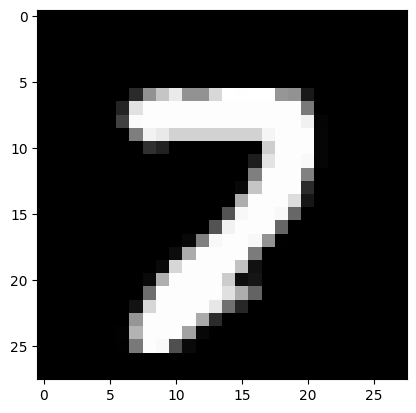

In [ ]:
plt.imshow(image_batch[0, 0, :, :].numpy(), cmap='gray')
# hier schreiben wir 0, 0 um das erste bild im batch zu sehen
# und :, : um alle pixel in höhe und breite zu sehen

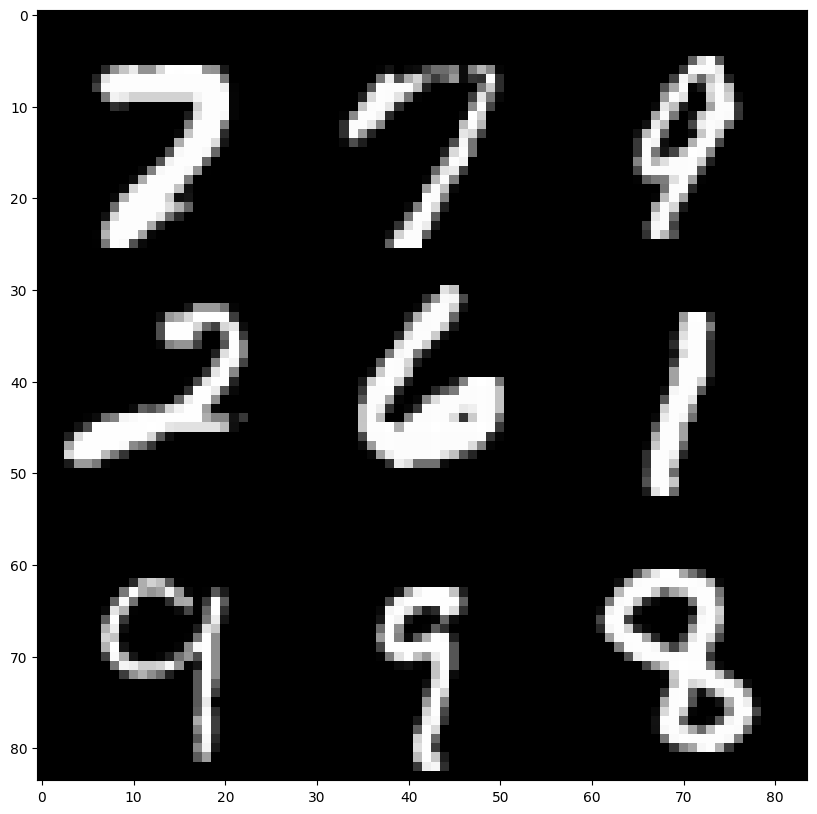

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image_batch[:9, 0, :, :]
           .reshape(3, 3, 28, 28)
           .permute(0, 2, 1, 3)
           .reshape(28*3, 28*3), cmap='gray')
plt.show()

In [ ]:
label_batch[:9]
# zeige labels der ersten 9 bilder im batch an

tensor([7, 7, 9, 2, 6, 1, 9, 9, 8])

Let's check the distribution of labels in the training set:

In [ ]:
train_dataset.targets.shape

torch.Size([60000])

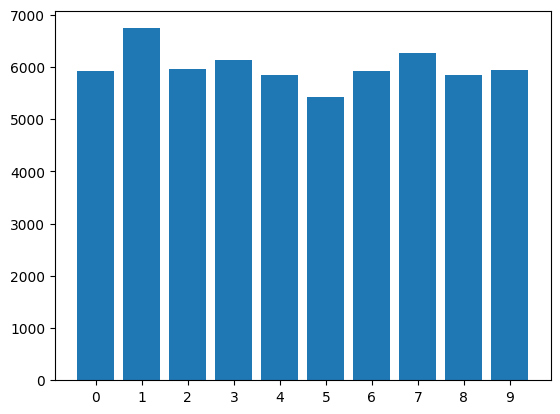

In [ ]:
counts = train_dataset.targets.bincount()
plt.bar(range(len(counts)), counts, tick_label=range(len(counts)))
plt.show()

## Feed Forward Neural Networks in `PyTorch`

![](nn.png "Example of a Feed Forward Neural Network")

Credit: https://alexlenail.me/NN-SVG/index.html

Each hidden neuron computes its output as a *weighted sum* of the neuron's inputs (plus a bias), followed by a *non-linear activation function* $h(x)$

$$ z = h \left( \sum_{i=1}^N w_i x_i + b \right) $$

where $x_1,\dots,x_N \in \mathbb{R}$ are the inputs to the neuron, and $w_1,\dots,w_N \in \mathbb{R}$, $b \in \mathbb{R}$ are their corresponding weights and biases.

## Defining the Network

Feed-forward neural network with 3 hidden layers in PyTorch:

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
      super(NeuralNet, self).__init__()
      self.fc1 = nn.Linear(in_features=28*28, out_features=128)
      self.fc2 = nn.Linear(in_features=128, out_features=128)
      self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):
      # Flatten the data (B, 1, 28, 28) => (B, 784), where B is the batch size
      # because nn.Linear expects 1D feature vectors
      x = torch.flatten(x, start_dim=1)

      # Pass data through 1st fully connected layer
      x = self.fc1(x)
      # Apply ReLU non-linearity
      x = F.relu(x)

      # Pass data through 2nd fully connected layer
      x = self.fc2(x)
      # Apply ReLU non-linearity
      x = F.relu(x)

      # Pass data through 3rd fully connected layer
      x = self.fc3(x)

      # Before passing x to the (log) softmax function,
      # the values in x are called *logits*.

      # Apply softmax to x (in log domain)
      log_probs = F.log_softmax(x, dim=1)

      return log_probs

The softmax function is given by

$$ \operatorname{softmax}(\mathbf{x})_k = \frac{\exp(x_k)}{\sum_{i=1}^D \exp(x_i)} $$

where $\mathbf{x} \in \mathbb{R}^D$.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = NeuralNet().to(device)
print(model)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
for p in model.parameters():
    print(p.shape)

torch.Size([128, 784])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


Let $\mathbf{x} \in \mathbb{R}^{28 \times 28}$ be the input image and $y \in \{0,\dots,9\}$ the label.

Our network $f_{\mathbf{\theta}}(\mathbf{x})$ models

$$f_{\mathbf{\theta}}(\mathbf{x}) = \left( \log p(y = 0 \, | \, \mathbf{x}), \ \log p(y = 1 \, | \, \mathbf{x}), \ \dots \ \log p(y = 9 \, | \, \mathbf{x}) \right)^\top$$

In [ ]:
x = image_batch[:1]
print(f'Shape: {x.shape}')

log_probs = model(x)
print(f'Model output: {log_probs}')

Shape: torch.Size([1, 1, 28, 28])
Model output: tensor([[-2.4502, -2.4402, -2.2620, -2.4194, -2.0513, -2.2453, -2.5179, -2.0816,
         -2.3855, -2.2866]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
probs = torch.exp(log_probs)
print(probs)
print(torch.sum(probs))

NameError: name 'torch' is not defined

## The Loss Function

In classification problems, it is common to use the *Negative-Log-Likelihood-Loss* (`NLLLoss`) (or, equivalently, the `CrossEntropyLoss`).
In `pytorch`, they differ just in what they expect as input:
+ `NLLLoss`: Expects log-probabilities as input
+ `CrossEntropyLoss`: Expects logits as input

In [ ]:
true_y = label_batch[:1]
true_y
print(true_y)

NameError: name 'label_batch' is not defined

In [ ]:
log_probs

tensor([[-2.4502, -2.4402, -2.2620, -2.4194, -2.0513, -2.2453, -2.5179, -2.0816,
         -2.3855, -2.2866]], grad_fn=<LogSoftmaxBackward0>)

In [ ]:
loss_fn = nn.NLLLoss()

loss_fn(log_probs, true_y)

tensor(2.0816, grad_fn=<NllLossBackward0>)

In [ ]:
-log_probs[0, true_y[0]]

tensor(2.0816, grad_fn=<NegBackward0>)

We can interpret this as the *cross entropy* between two probability mass functions: Given some $(\mathbf{x}_i, y_i) \in \mathcal{D}$, we compare the *empirical* distribution
$$p_{\mathcal{D}}(y \, | \, \mathbf{x}_i) = \begin{cases} 1 & \text{ if } y = y_i \\ 0 & \text{ else} \end{cases}$$
and the distribution predicted by the model $p_{\mathbf{\theta}}(y \, | \, \mathbf{x}_i)$.
That is,
$$\mathbb{H}_{\text{ce}}(p_{\mathcal{D}}(\cdot \, | \, \mathbf{x}_i), \ p_{\mathbf{\theta}}(\cdot \, | \, \mathbf{x}_i)) = \mathbb{E}_{y \sim p_{\mathcal{D}}(\cdot \, | \, \mathbf{x}_i)} \left[ -\log(p_{\mathbf{\theta}}(y \, | \, \mathbf{x}_i)) \right]  = -\log(p_{\mathbf{\theta}}(y_i \, | \, \mathbf{x}_i))$$
which just *selects* the negative log probability of the observed label.

## Training the model

We will use *Stochastic Gradient Descent* (`SGD`) to minimize the `NLLLoss` (i.e., to train the model).

In [ ]:
learning_rate = 0.01
num_epochs = 5

model = NeuralNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

losses = []
for epoch in range(num_epochs):
    print('-'*20, f'Epoch {epoch}', '-'*20)
    # Train one epoch
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        log_probs = model(data)
        loss = loss_fn(log_probs, target)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if batch_idx % 100 == 0:
            print(f'Train Epoch {epoch} | Loss: {loss.item()}')

    print(f'\nAverage train loss in epoch {epoch}: {np.mean(losses[-len(train_loader):])}')

    # Evaluate on test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            log_probs = model(data)
            test_loss += F.nll_loss(log_probs, target, reduction='sum').item()  # sum up batch loss
            pred = torch.argmax(log_probs, dim=1)  # get the index of the max log-probability
            correct += (pred == target).sum().item()

    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * avg_correct:.0f}%)\n')

-------------------- Epoch 0 --------------------
Train Epoch 0 | Loss: 2.343956470489502
Train Epoch 0 | Loss: 1.872715711593628
Train Epoch 0 | Loss: 1.0158917903900146
Train Epoch 0 | Loss: 0.6910825967788696
Train Epoch 0 | Loss: 0.5692405104637146
Train Epoch 0 | Loss: 0.5082194805145264
Train Epoch 0 | Loss: 0.29954636096954346
Train Epoch 0 | Loss: 0.318524569272995
Train Epoch 0 | Loss: 0.26610809564590454
Train Epoch 0 | Loss: 0.2892531156539917

Average train loss in epoch 0: 0.7692796946652154
Test set: Average loss: 0.3319, Accuracy: 9071/10000 (91%)

-------------------- Epoch 1 --------------------
Train Epoch 1 | Loss: 0.3639354109764099
Train Epoch 1 | Loss: 0.1784091293811798
Train Epoch 1 | Loss: 0.3085453510284424
Train Epoch 1 | Loss: 0.4029926657676697
Train Epoch 1 | Loss: 0.259451299905777
Train Epoch 1 | Loss: 0.21448805928230286
Train Epoch 1 | Loss: 0.24751344323158264
Train Epoch 1 | Loss: 0.15388669073581696
Train Epoch 1 | Loss: 0.16825920343399048
Train Ep

## Plot Loss Curve

4690


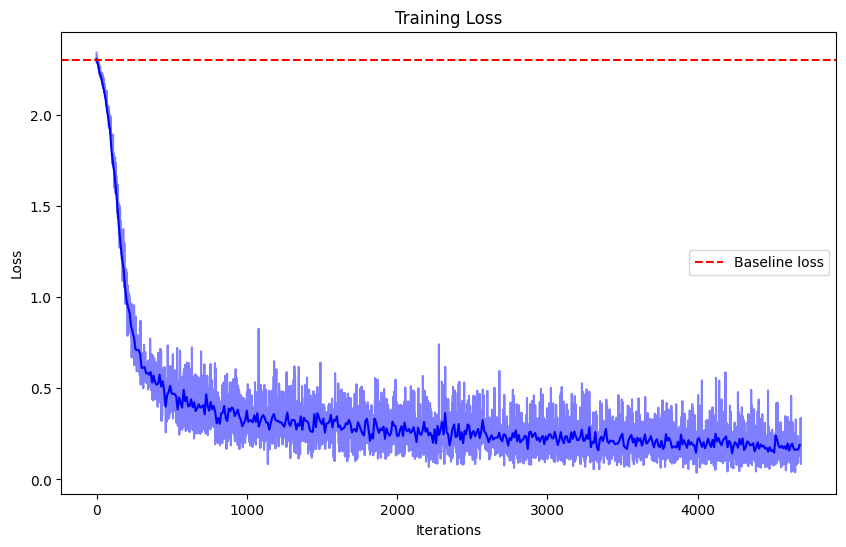

In [37]:
losses_smoothed = np.array(losses).reshape(-1, 10).mean(axis=1) # average every 10 batch losses
print(len(losses))
steps = np.arange(len(losses))

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, 'b', alpha=0.5)
plt.plot(steps[::10], losses_smoothed, 'b')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# plot horizontal line at baseline loss
plt.axhline(y=-np.log(0.1), color='r', linestyle='--', label='Baseline loss')
plt.legend(loc='right')
plt.show()